<a href="https://colab.research.google.com/github/hosein-jamshidian/Fashion_MNIST_using_ResNet/blob/main/Fashion_MNIST_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

#print(tfds.list_builders())
dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteUUN24A/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteUUN24A/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmpxoqdoethtfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitI

In [2]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 128

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

In [3]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

In [4]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add

from tensorflow.keras import Model

In [5]:
class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()

        channel = channel_out // 4

        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)

        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)

        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()

        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)

    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)

        h = self.conv3(h)
        h = self.bn3(h)

        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)

    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

In [6]:
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()

        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),

            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)
            ],

            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)
            ],

            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)
            ],

            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],

            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]

    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)
            else:
                x = layer(x)
        return x


model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 75904     
 ck)                                                             
                                                         

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay =  0.0001)

In [8]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [9]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)

In [10]:
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [12]:
import time

num_epoch = 50
start_time = time.time()

train_accuracies = []
test_accuracies = []

for epoch in range(num_epoch):
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break

    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)

    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, round(spent_time / 60,2)))


Epoch 1, Loss: 0.3814479112625122, Accuracy: 85.65709686279297, Test Loss: 0.358837753534317, Test Accuracy: 86.95999908447266, spent_time: 0.5865753769874573 min
Epoch 2, Loss: 0.37545183300971985, Accuracy: 85.88734436035156, Test Loss: 0.35416245460510254, Test Accuracy: 87.1673355102539, spent_time: 1.1785935362180073 min
Epoch 3, Loss: 0.36998632550239563, Accuracy: 86.09087371826172, Test Loss: 0.34949731826782227, Test Accuracy: 87.35625457763672, spent_time: 1.6942277113596598 min
Epoch 4, Loss: 0.3646099269390106, Accuracy: 86.2993392944336, Test Loss: 0.34772786498069763, Test Accuracy: 87.4811782836914, spent_time: 2.2104581435521444 min
Epoch 5, Loss: 0.35977500677108765, Accuracy: 86.47783660888672, Test Loss: 0.34624308347702026, Test Accuracy: 87.58943939208984, spent_time: 2.7168206771214805 min
Epoch 6, Loss: 0.3551628887653351, Accuracy: 86.65496826171875, Test Loss: 0.3438708484172821, Test Accuracy: 87.70420837402344, spent_time: 3.2393178423245748 min
Epoch 7, Loss

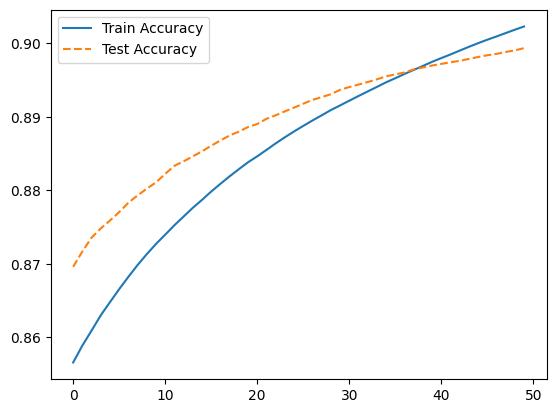

In [13]:

import matplotlib.pyplot as plt

plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

# something like this :
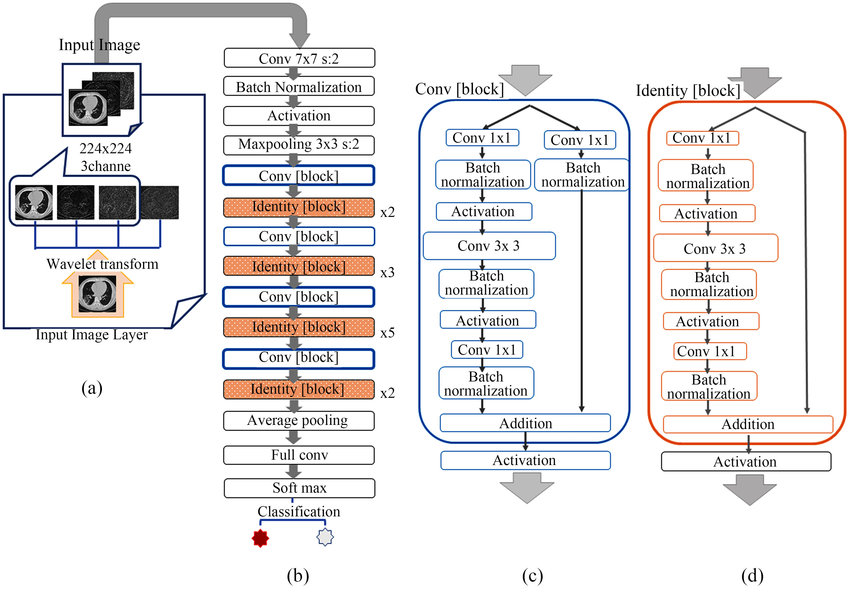